In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend

In [2]:
def sample_real_images(image_array, batch_size, seed):
    random_images = image_array[np.random.choice(image_array.shape[0], size=batch_size, replace=True)]
    return random_images

In [3]:
def generator_noise(latent_dim, batch_size):
    noise = np.random.randn(batch_size, latent_dim)
    return noise

In [4]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [5]:
# <https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/>
# mini-batch standard deviation layer
class MinibatchStdev(Layer):
    # initialize the layer
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # perform the operation
    def call(self, inputs):
        # calculate the mean value for each pixel across channels
        mean = backend.mean(inputs, axis=0, keepdims=True)
        # calculate the squared differences between pixel values and mean
        squ_diffs = backend.square(inputs - mean)
        # calculate the average of the squared differences (variance)
        mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
        # add a small value to avoid a blow-up when we calculate stdev
        mean_sq_diff += 1e-8
        # square root of the variance (stdev)
        stdev = backend.sqrt(mean_sq_diff)
        # calculate the mean standard deviation across each pixel coord
        mean_pix = backend.mean(stdev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = backend.shape(inputs)
        output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        combined = backend.concatenate([inputs, output], axis=-1)
        return combined

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
    # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

#### Data Import and Cleansing

In [6]:
image_folder = 'C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\MNIST\\Data'

In [7]:
# pixels = pd.read_csv(image_folder+'\\icml_transformed_images.csv')
# pixels.drop(columns=['Unnamed: 0'], inplace=True)
# pixels = pixels.astype('float')/255

In [8]:
images = pd.read_csv(image_folder+'\\train.csv')
pixels = images.drop(columns=['label'])
pixels = pixels.astype('float')/255
labels = images['label']

In [9]:
# labels = pd.read_csv(image_folder+'\\icml_labels.csv')
# labels.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
image_ct = pixels.shape[0]
square_dim = int(np.sqrt(pixels.shape[1]))
images = np.array(pixels).reshape(image_ct, square_dim, square_dim, 1)

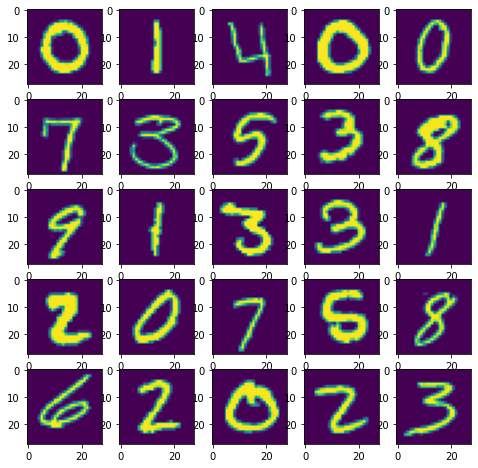

In [11]:
columns = 5
rows = 5
fig = pl.figure(figsize=(8,8))
for i in range(1, columns*rows+1):
    image = images[i].reshape(square_dim, square_dim)
    fig.add_subplot(rows, columns, i)
    pl.imshow(image)
pl.show()

#### Discriminator

In [12]:
discriminator_lr = 1e-6
generator_lr = discriminator_lr/3

In [13]:
input_dim = images[0].shape[0]

In [14]:
final_conv_layer_name = 'final_conv2d'

In [15]:
# discriminator = Sequential(name='Discriminator')
# discriminator.add(Input(shape=(input_dim, input_dim, 1)))
# discriminator.add(SpectralNormalization(Conv2D(filters=16, kernel_size=16)))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(MinibatchStdev())
# discriminator.add(SpectralNormalization(Conv2D(filters=24, kernel_size=12)))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.2))
# discriminator.add(SpectralNormalization(Conv2D(filters=40, kernel_size=10)))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.2))
# discriminator.add(SpectralNormalization(Conv2D(filters=56, kernel_size=6)))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.2))
# discriminator.add(SpectralNormalization(Conv2D(filters=72, kernel_size=5), name=final_conv_layer_name))
# discriminator.add(LeakyReLU(alpha=0.2))
# discriminator.add(Dropout(0.2))
# discriminator.add(Flatten())
# discriminator.add(Dropout(0.5))
# discriminator.add(Dense(1, activation='sigmoid'))

In [16]:
discriminator = Sequential(name='Discriminator')
discriminator.add(Input(shape=(input_dim, input_dim, 1)))
discriminator.add(SpectralNormalization(Conv2D(filters=16, kernel_size=8)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(MinibatchStdev())
discriminator.add(SpectralNormalization(Conv2D(filters=24, kernel_size=6)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.2))
discriminator.add(SpectralNormalization(Conv2D(filters=40, kernel_size=5)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.2))
discriminator.add(SpectralNormalization(Conv2D(filters=56, kernel_size=3)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.2))
discriminator.add(SpectralNormalization(Conv2D(filters=72, kernel_size=2), name=final_conv_layer_name))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(10, activation='softmax'))

In [17]:
discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=discriminator_lr))

In [18]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectral_normalization (Spe  (None, 21, 21, 16)       1056      
 ctralNormalization)                                             
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 21, 21, 16)        0         
                                                                 
 minibatch_stdev (MinibatchS  (None, 21, 21, 17)       0         
 tdev)                                                           
                                                                 
 spectral_normalization_1 (S  (None, 16, 16, 24)       14736     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 24)        0         
                                                     

#### Generator

In [19]:
latent_gan_dim = 100

In [20]:
final_conv_layer_shape = discriminator.get_layer(final_conv_layer_name).output.shape
final_conv_window_dim = final_conv_layer_shape[1]
final_conv_filters_dim = final_conv_layer_shape[3]

In [21]:
layer_1_param_ct = (final_conv_window_dim**2)*final_conv_filters_dim

In [22]:
generator = Sequential(name='Generator')
generator.add(Dense(layer_1_param_ct,input_dim=latent_gan_dim))
generator.add(Reshape(target_shape=(final_conv_window_dim, final_conv_window_dim, final_conv_filters_dim)))
generator.add(SpectralNormalization(Conv2DTranspose(filters=90, kernel_size=2)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(SpectralNormalization(Conv2DTranspose(filters=72, kernel_size=3)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(SpectralNormalization(Conv2DTranspose(filters=60, kernel_size=4)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(SpectralNormalization(Conv2DTranspose(filters=44, kernel_size=5)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(SpectralNormalization(Conv2DTranspose(filters=28, kernel_size=10)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Conv2D(filters=1, kernel_size=1, activation='tanh'))

In [23]:
# generator.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=4e-4, momentum=0))
# generator.summary()

#### GAN

In [24]:
gan = Sequential(name='GAN')
gan.add(generator)
gan.add(discriminator)

In [25]:
discriminator.trainable = False

In [26]:
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=generator_lr))

In [27]:
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 28, 28, 1)         932253    
                                                                 
 Discriminator (Sequential)  (None, 10)                134746    
                                                                 
Total params: 1,066,999
Trainable params: 931,915
Non-trainable params: 135,084
_________________________________________________________________


#### Training

In [28]:
discriminator_path = 'C:\\Users\\rbush\\Documents\\Projects\\GANs\\discriminator.h5'
generator_path = 'C:\\Users\\rbush\\Documents\\Projects\\GANs\\generator.h5'

In [29]:
num_epochs = 10000
batch_size_gan = images.shape[0]

In [30]:
discriminator_iters = 1
generator_iters = 1


---------------------------------------------------------------------------------------- 
Epoch 1:
Discriminator training loop 1
1313/1313 [==============================] - 13s 10ms/step - loss: 18.8922


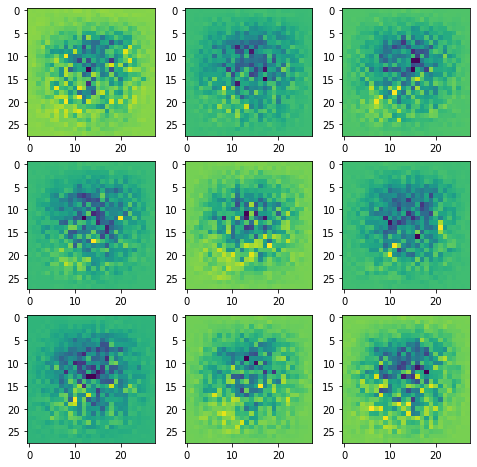

Generator training loop 1
1313/1313 [==============================] - 27s 19ms/step - loss: 0.9962

---------------------------------------------------------------------------------------- 
Epoch 2:
Discriminator training loop 1
1313/1313 [==============================] - 13s 10ms/step - loss: 18.9774
Generator training loop 1
1313/1313 [==============================] - 28s 21ms/step - loss: 3.3795

---------------------------------------------------------------------------------------- 
Epoch 3:
Discriminator training loop 1
1313/1313 [==============================] - 15s 11ms/step - loss: 19.0688
Generator training loop 1
1313/1313 [==============================] - 27s 21ms/step - loss: 7.4823

---------------------------------------------------------------------------------------- 
Epoch 4:
Discriminator training loop 1
1313/1313 [==============================] - 16s 12ms/step - loss: 19.3060
Generator training loop 1
1313/1313 [==============================] - 28s 21ms/step 

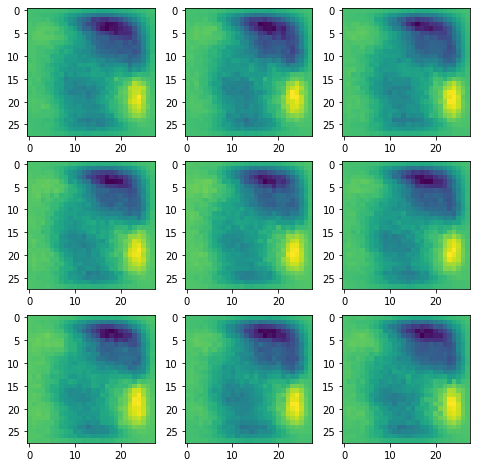

Generator training loop 1
 268/1313 [=====>........................] - ETA: 21s - loss: 76.5419

KeyboardInterrupt: 

In [31]:
seed = 1
progress_interval = 10
num_vis = 9
columns, rows = int(np.sqrt(num_vis)), int(np.sqrt(num_vis))
noise_factor = 15
for epoch in range(1,num_epochs+1):
    print('\n----------------------------------------------------------------------------------------',
          f'\nEpoch {epoch}:')    
    # Discriminator training loop
    for i in range(1,discriminator_iters+1):
        print(f'Discriminator training loop {i}')
        imgs_real = sample_real_images(image_array=images, batch_size=batch_size_gan, seed=seed)
        noise = generator_noise(latent_dim=latent_gan_dim, batch_size=batch_size_gan)
        imgs_fake = generator.predict(noise)
        noisy_real_labels = np.zeros((batch_size_gan, 10))+(np.random.randint(0,noise_factor,(batch_size_gan, 10))/100)+0.1
        noisy_fake_labels = np.ones((batch_size_gan, 10))+(np.random.randint((-1*noise_factor),0,(batch_size_gan, 10))/100)-0.1
        discriminator.fit(imgs_real, noisy_real_labels)
        discriminator.fit(imgs_fake, noisy_fake_labels)

    # Visualize fake image generation
    if seed % progress_interval == 0 or seed == 1:
        noise = generator_noise(latent_gan_dim, num_vis+1)
        imgs_fake = generator.predict(noise)
        fig = pl.figure(figsize=(8,8))
        for i in range(1, columns*rows+1):
            image = imgs_fake[i].reshape(square_dim,square_dim)
            fig.add_subplot(rows, columns, i)
            pl.imshow(image)
        pl.show()

    # Generator training loop
    for j in range(1,generator_iters+1):
        print(f'Generator training loop {j}')
        labels = np.zeros((batch_size_gan, 10))
        noise = generator_noise(latent_gan_dim, batch_size_gan)
        gan.fit(noise, labels)
    
    seed += 1